### MonthlySVD
This code shows as simple way to:
- Read in a .nc file using xarray
- Generate montly anomalies from climatology of monthly means
- detrend data by grid cell
- calculate singular value decomposition by grid cell, dim = month * year


In [1]:
import xarray as xr
import cf_units as cf
import numpy as np
import pandas as pd
import esmlab
from ctsm_py import utils

# Try scipy to detrend
import segment as sg
import scipy
from scipy import signal

# some resources for plotting
import matplotlib.pyplot as plt
#import cartopy
#import cartopy.crs as ccrs
%matplotlib inline

In [2]:
## User defined options
model = 'CLM5_GSWP3'
var  = ['GPP','TBOT','SOILWATER_10CM']
suff = 'lnd/proc/tseries/month_1/'
path = '/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/'+suff
file0 = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var[0] +'.185001-201412.nc'
file1 = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var[1] +'.185001-201412.nc'
file2 = path + 'clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.'+ var[2] +'.185001-201412.nc'
file0

'/glade/p/cgd/tss/people/oleson/CLM_LAND_ONLY_RELEASE/CLM5/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist/lnd/proc/tseries/month_1/clm50_r270_1deg_GSWP3V1_iso_newpopd_hist.clm2.h0.GPP.185001-201412.nc'

#### Read in your data

In [3]:
# wrapping the time_set_mid utility corrects time being read in by xr.open_dataset
# data sets have lots of coords, variables, and attributes
# ?? TODO, is there a more efficient way of reading in multiple variables into a signle dataset??
ds0   = utils.time_set_mid(xr.open_dataset(file0, decode_times=True), 'time')
ds1   = utils.time_set_mid(xr.open_dataset(file1, decode_times=True), 'time')
ds2   = utils.time_set_mid(xr.open_dataset(file2, decode_times=True), 'time')
area = ds0.area
landfrac = ds0.landfrac
ds = xr.merge([ds0, ds1, ds2])
print(ds)

<xarray.Dataset>
Dimensions:         (hist_interval: 2, lat: 192, levdcmp: 25, levgrnd: 25, levlak: 10, lon: 288, time: 1980)
Coordinates:
  * lat             (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * levdcmp         (levdcmp) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levgrnd         (levgrnd) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levlak          (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.325 44.775
  * lon             (lon) float32 0.0 1.25 2.5 3.75 ... 356.25 357.5 358.75
  * time            (time) object 1850-01-16 11:45:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: hist_interval
Data variables:
    BSW             (levgrnd, lat, lon) float32 nan nan nan nan ... nan nan nan
    DZLAKE          (levlak, lat, lon) float32 nan nan nan nan ... nan nan nan
    DZSOI           (levgrnd, lat, lon) float32 0.02 0.02 0.02 ... nan nan nan
    GPP             (time, lat, lon) float32 ...
    HKSAT           (levgrnd, lat, lon) float32

### Quick look at annual cycle for a grid cell

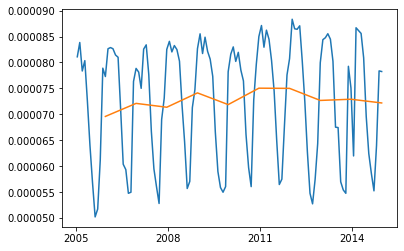

In [4]:
years = 10
months = years * 12
tlat = -5 #60 #-5
tlon = 300 # 240# 300
ds_test = ds.sel(lat=tlat, lon=tlon, method='nearest') #select a single grid point to work with first
ds_last = ds_test.isel(time=slice(-months,None))
dataset = ds_last.get(var)
ds_ann  = dataset.apply(utils.weighted_annual_mean)
plt.plot(ds_last.time['time'], ds_last.get(var[0]), '-' );
plt.plot(ds_ann.time['time'], ds_ann.get(var[0]), '-' );

### Calculate climatology and anomalies

Text(0, 0.5, 'SOILWATER_10CM')

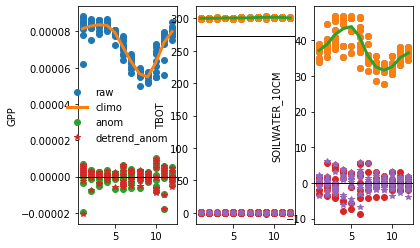

In [5]:
# esmlab anomaly function needs time_bounds in the dataset!
# test to see of climatology and anomaly functions see to work appropriately?
ds_climo = esmlab.core.climatology(ds_last,freq='mon')
ds_anom = esmlab.core.anomaly(ds_last, clim_freq='mon', time_coord_name='time')
ds_detrend0 = signal.detrend(ds_anom.get(var[0]))
ds_detrend1 = signal.detrend(ds_anom.get(var[1]))
ds_detrend2 = signal.detrend(ds_anom.get(var[2]))


plt.subplot(1, 3, 1)
plt.plot(ds_last.time['time.month'], ds_last.get(var[0]), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[0]), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[0]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend0, '*' );
plt.legend(labels=('raw','climo','anom','detrend_anom'),frameon = False)
plt.axhline(0, color='black', lw=1);
plt.ylabel(var[0])

plt.subplot(1, 3, 2)
plt.plot(ds_last.time['time.month'], ds_last.get(var[1]), 'o' );
plt.plot(ds_last.time['time.month'], ds_last.get(var[1]), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[1]), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[1]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend1, '*' );
plt.axhline(273.15, color='black', lw=1);
plt.ylabel(var[1])

plt.subplot(1, 3, 3)
plt.plot(ds_last.time['time.month'], ds_last.get(var[2]), 'o' );
plt.plot(ds_last.time['time.month'], ds_last.get(var[2]), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[2]), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[2]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend2, '*' );
plt.axhline(0., color='black', lw=1);
plt.ylabel(var[2])


Text(0, 0.5, 'GPP')

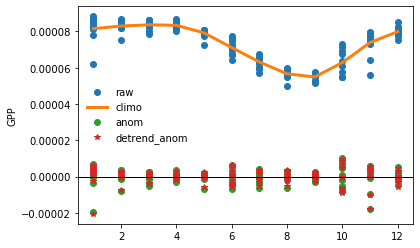

In [6]:
plt.plot(ds_last.time['time.month'], ds_last.get(var[0]), 'o' );
plt.plot(ds_climo.time['time.month'], ds_climo.get(var[0]), '-', lw=3 );
plt.plot(ds_anom.time['time.month'], ds_anom.get(var[0]), 'o' );
plt.plot(ds_anom.time['time.month'], ds_detrend0, '*' );
plt.legend(labels=('raw','climo','anom','detrend_anom'),frameon = False)
plt.axhline(0, color='black', lw=1);
plt.ylabel(var[0])

### Do we need to detrend data?

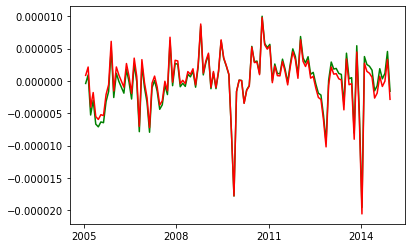

In [7]:
plt.plot(ds_anom.time['time'], ds_anom.get(var[0]), '-',c='green' )
plt.plot(ds_anom.time['time'], ds_detrend0, '-' ,c='red');

### Start singular vector decomposition
#### This is from Gretchen's CLM_SVD code 

10


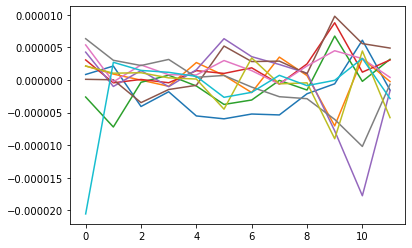

In [8]:
# Reshape month x year
# uniqueyears=np.unique(ds_detrend.time['time.year'])
# iavmatrix=np.zeros([12, len(uniqueyears)])
iavmatrix=np.zeros([12, years])
for iyr in range(years):
    iavmatrix[0:12, iyr]=ds_detrend0[iyr*12:(iyr+1)*12] #reshape timeseries vector into a matrix (year x month) 
#print(iavmatrix.shape)
#print(iavmatrix)
#print(ds_anom.get(var)[0:12])
print(years)
plt.figure();
plt.plot(iavmatrix);

In [9]:
import SVD_tools as svd
monthlimits=np.array([0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
DOYlimits=np.cumsum(monthlimits)
print(iavmatrix.shape)

(12, 10)


In [10]:
U, s, V = np.linalg.svd(iavmatrix, full_matrices=False)
Nyears=iavmatrix.shape[1]
Nmonths=iavmatrix.shape[0]
S = np.diag(s)

# IF Nmonth < Nyears
# Sigma needs to have same dimensions as iavMatrix (12,nyear)
'''We can achieve this by creating a new Sigma matrix of all zero values that is 
   m x n (e.g. more rows) and populate the first n x n part of the matrix with 
   the square diagonal matrix calculated via diag().
   https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/
   '''
# create m x n Sigma matrix
Sigma = np.zeros((Nmonths, Nyears))
# populate Sigma with n x n diagonal matrix
# Sigma[:Nmonths, :Nmonths] = np.diag(s)

print('U = ',U.shape)  #(nmonth,nmonth)
print('S = ',S.shape)  #(nmonth,nmonth)
print('s = ',s.shape)  #(nmonth,)
print('V = ',V.shape)  #(nmonth,nyear)
print('Sigma = ',Sigma.shape)
#print(Nyears, Nmonths)
sv_vectors = np.zeros((Nyears,Nmonths),dtype='float')
sv_weights = np.zeros((Nyears,Nyears),dtype='float')
##Here we define the vector shapes by taking the dot product of U and S. 
##0 and 1 refer to the first and second singular vector, respectively
for iyear in range(Nyears):
    sv_vectors[iyear,:]=np.dot(U,S)[:,iyear]
    sv_weights[iyear,:]=V[iyear,:]  
print('sv_vector = ',sv_vectors.shape)
print('sv_weights = ',sv_weights.shape)
            

U =  (12, 10)
S =  (10, 10)
s =  (10,)
V =  (10, 10)
Sigma =  (12, 10)
sv_vector =  (10, 12)
sv_weights =  (10, 10)


In [11]:
#assign the 2-D matrix (year x month) to decompose
## TODO, the decompose functions doesn't like to work with too many years of data?  
[vectors, weights]=svd.decompose(iavmatrix) #Call the function to calculate the singular vectors and their annual weights

[theta,varfrac]=svd.calc_redistribution(vectors, weights, iavmatrix)
varfrac.shape

12 10
[0.07257521 0.76355612 0.0488953  0.70332614 0.11736019 0.38549865
 0.45315595 0.15205922 0.13357136 0.12019359]


(10,)

[-3.83113606e-06 -2.08419570e-07 -8.51436813e-07 -2.17182103e-07
 -6.88607943e-07 -1.52498105e-06 -9.36300309e-07 -2.16714343e-07
  1.13774306e-08  3.75376079e-06  5.32355313e-06  7.12466842e-07]
(10, 12)
(10, 10)


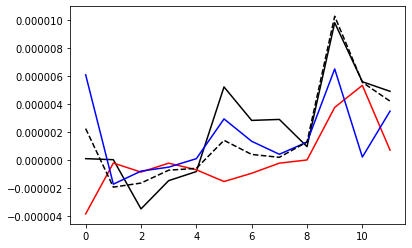

In [12]:
# sanity check make sure that the  first two singular vectors generally reproduce the IAV for a given year
year2check=5
Obs=iavmatrix[:,year2check]
SV1contrib=vectors[0,:]*weights[0,year2check]
SV2contrib=vectors[1,:]*weights[1,year2check]
SV3contrib=vectors[2,:]*weights[2,year2check]
print(SV1contrib)
plt.plot(Obs, 'k-')
plt.plot(SV1contrib, 'r-')
plt.plot(SV2contrib, 'b-')
#plt.plot(SV3contrib, 'g-')
plt.plot(SV1contrib+SV2contrib, 'k--')
print(vectors.shape)
print(weights.shape)
#print(weights)
#plt.figure(3)
#plt.plot(sif_years_anomaly[:,5],'k-',label="Obs")
#plt.plot(sv_vectors_sif[0,:]*sv_weights_sif[0,5],'r-',label="SV1")
#plt.plot(sv_vectors_sif[1,:]*sv_weights_sif[1,5],'b-',label="SV2")
#plt.plot(sv_vectors_sif[0,:]*sv_weights_sif[0,5]+sv_vectors_sif[1,:]*sv_weights_sif[1,5],'k--',label="SV1+2")

1.469862185050449e-05


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


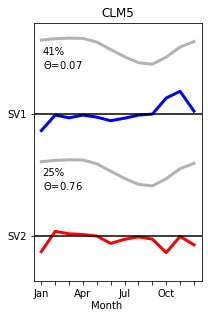

In [13]:
##Plot First and Second Singular Vectors
fig = plt.figure(4,figsize=(3,4.5))
ax1 = fig.add_subplot(111)
month = np.arange(12)
barwidth = 0.2
ymax=np.max(vectors)
print(ymax)
vectors2plot=vectors*5000  #This is a totally arbitrary scale factor, decided by me, to make figures look good!
#mm2plot=mm
mm2plot=ds_climo.get(var[0])
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))-0.05,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,mm2plot/(4*max(mm2plot))+0.35,'k-',alpha=0.3,linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[0,:]*0.75+0.35,'b-',linewidth=3)
ax1.plot(np.array(month)+2*barwidth,-vectors2plot[1,:]*0.75-0.05,'r-',linewidth=3)
ax1.axhline(-0.05,color='black')
ax1.axhline(0.35,color='black')
ax1.set_xticks(np.array(month)+2*barwidth)
ax1.set_xticklabels(['Jan','','','Apr','','','Jul','','','Oct','',''])
ax1.set_yticks([-0.05,0.35])
ax1.set_yticklabels(['SV2','SV1'])
ax1.set_ylim([-0.2,0.65])
ax1.text(0.5,.5,str(int(varfrac[0]*100))+"%\n$\Theta$="+str('%.2f'%theta[0]))
ax1.text(0.5,.1,str(int(varfrac[1]*100))+"%\n$\Theta$="+str('%.2f'%theta[1]))
ax1.title.set_text('CLM5')
ax1.text(4,-0.29,'Month')
plt.tight_layout()
plt.savefig('SVD_CLM5_ex.eps') ;


In [14]:
print(weights.shape)

(10, 10)


### Calculate global anomalies

/glade/u/home/wwieder/miniconda3/envs/python-tutorial/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(120, 192, 288)


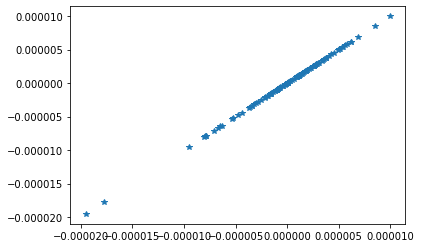

In [15]:
ds2 = ds.isel(time=slice(-months,None))
ds_climo2 = esmlab.core.climatology(ds2,freq='mon')
ds_anom2  = esmlab.core.anomaly(ds2, clim_freq='mon', time_coord_name='time') #not sure how to use slice_mon_clim_time
ds_anom2    
ds_temp = ds_anom2.sel(lat=tlat, lon=tlon, method='nearest') #select a single grid point to work with first
plt.plot(ds_temp.get(var[0]), ds_anom.get(var[0]), '*' )
anom_np = ds_anom2.get(var[0]).values # returns a 3d array with dims (time,lat,lon)
print(anom_np.shape)

In [16]:
## define function that wraps in detrending, reshaping, and SVD & returns a np.array
def svd_wrap(anom, years=years):
    theta = np.full(years, np.nan)
    varfrac = np.full(years, np.nan)
    if np.isnan(anom)[0] == False:
        #detrend results, if needed
        detrend = signal.detrend(anom)  
    
        #reshape timeseries vector into a matrix (year x month) 
        matrix=np.zeros([12, years])
        for iyr in range(years):
            matrix[0:12, iyr]=detrend[iyr*12:(iyr+1)*12] 
    
        #Call the function to calculate the singular vectors and their annual weights
        [vectors, weights]=svd.decompose(matrix) 
        [theta,varfrac]=svd.calc_redistribution(vectors, weights, matrix)

    return theta, varfrac, vectors, weights


In [17]:
print(ds_temp.get(var[0]))

<xarray.DataArray 'GPP' (time: 120)>
array([-3.998284e-07,  9.124997e-07, -5.272886e-06, -2.988934e-06,
       -6.681337e-06, -7.101444e-06, -6.343886e-06, -6.462524e-06,
       -3.192796e-06, -1.644614e-06,  5.066177e-06, -2.568573e-06,
        1.153727e-06, -6.684422e-08, -9.732175e-07, -1.898283e-06,
        1.766122e-06, -1.868466e-07, -2.800971e-06,  2.663008e-06,
       -1.525950e-07, -7.846673e-06,  2.495501e-06, -1.002285e-06,
       -3.356741e-06, -7.936651e-06, -1.056047e-06,  5.689071e-08,
       -1.579450e-06, -4.391564e-06, -3.690049e-06, -6.570663e-07,
       -2.116230e-06,  6.186179e-06, -7.422059e-07,  2.668348e-06,
        2.586341e-06, -9.049545e-07, -3.664900e-07, -8.530114e-07,
        1.024637e-06,  6.224800e-07,  1.501699e-06, -9.752730e-07,
        2.144192e-06,  8.479648e-06,  9.222640e-07,  2.811954e-06,
        4.035297e-06, -1.213542e-06,  1.250708e-06, -1.205975e-06,
        1.407258e-06,  6.203561e-06,  3.465175e-06,  2.287346e-06,
        9.645591e-07, -7.

[0.07257521 0.76355612 0.0488953  0.70332614 0.11736019 0.38549865
 0.45315595 0.15205922 0.13357136 0.12019359]
12 10
[0.0725752  0.76355612 0.04889536 0.7033262  0.11736005 0.38549865
 0.45315586 0.15205947 0.13357114 0.12019494]
----
[4.10718468e-01 2.55567491e-01 1.66232493e-01 8.12740036e-02
 3.19976097e-02 2.68291930e-02 1.77781262e-02 6.04037803e-03
 3.53751414e-03 3.50734427e-05]
!!!
[4.10718458e-01 2.55567507e-01 1.66232489e-01 8.12739991e-02
 3.19976128e-02 2.68291912e-02 1.77781262e-02 6.04037786e-03
 3.53751495e-03 3.50742710e-05]


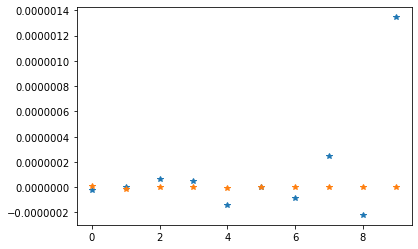

In [18]:
# Make sure wrapper results are the same as above
print(theta)
[theta_wrap, varfrac_wrap, vectors_wrap, weights_wrap] = svd_wrap(ds_temp.get(var[0]).values, years)
plt.plot(theta_wrap - theta, '*') ;
plt.plot(varfrac_wrap - varfrac, '*') ;

print('----')
print(varfrac_wrap)
print('!!!')
print(varfrac)

In [19]:
print(anom_np[:,150,50].shape)
print(ds_temp.get(var[0]).values.shape)
print(np.isnan(anom_np[:,150,50])[0])

[theta_wrap, varfrac_wrap, vectors_wrap, weights_wrap] = svd_wrap(anom_np[:,150,50], years)
print(theta_wrap.shape)
print(varfrac_wrap.shape)
print(vectors_wrap.shape)
print(weights_wrap.shape)
print([years,years])

(120,)
(120,)
False
12 10
[0.66061408 0.98792047 0.27642666 0.16707264 0.15010149 0.34007093
 0.96848032 0.01716391 0.16040016 0.18591887]
(10,)
(10,)
(10, 12)
(10, 10)
[10, 10]


In [20]:
# Now try this on the full dataset
# svd_global = xr.apply_ufunc(svd_wrap, anom_np, years, vectorize=True)
da = ds.get(var[0])
dims = dict(zip(da.dims, da.shape))
#print(dims)
#print(years)
print(da.isel(lat=1, lon=1).data)
varnames = ['theta', 'varfrac', 'vectors', 'weights']
out = xr.Dataset()
theta_shape =  (10, )
out['theta'] = xr.DataArray(np.zeros(theta_shape), dims=('thetadim'))
out['varfrac'] = xr.DataArray(np.zeros(theta_shape), dims=('varfracdim'))
vector_shape = (10, 12)
out['vectors'] = xr.DataArray(np.zeros(vector_shape), dims=('vectors_dim1', 'vector_dim2'))
weights_shape = (10, 10)
out['weights'] = xr.DataArray(np.zeros(weights_shape), dims=('weights_dim1', 'weights_dim2'))
    
return_vals = svd_wrap(da.isel(lat=90, lon=230).data)
for varname, vals in zip(varnames, return_vals):
    out[varname][...] = vals
    
print(out)



[0. 0. 0. ... 0. 0. 0.]
12 10
[0.85974048 0.55402355 0.369568   0.15941633 0.18198298 0.22060984
 0.03998443 0.12652422 0.03596969 0.20385865]
<xarray.Dataset>
Dimensions:  (thetadim: 10, varfracdim: 10, vector_dim2: 12, vectors_dim1: 10, weights_dim1: 10, weights_dim2: 10)
Dimensions without coordinates: thetadim, varfracdim, vector_dim2, vectors_dim1, weights_dim1, weights_dim2
Data variables:
    theta    (thetadim) float64 0.8597 0.554 0.3696 ... 0.1265 0.03597 0.2039
    varfrac  (varfracdim) float64 0.4928 0.2379 0.179 ... 0.003896 0.000669
    vectors  (vectors_dim1, vector_dim2) float64 -1.091e-05 ... 5.636e-07
    weights  (weights_dim1, weights_dim2) float64 -0.3196 -0.4725 ... 0.07476


In [70]:
def calc_svd(da):

    dims = dict(zip(da.dims, da.shape))
    yx_shape = (dims['lat'], dims['lon'])
    # setup output variables
    out = xr.Dataset()
    varnames = ['theta', 'varfrac', 'vectors', 'weights']
    theta_shape = yx_shape + (10, )
    out['theta'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'thetadim'))
    out['varfrac'] = xr.DataArray(np.zeros(theta_shape), dims=('lat', 'lon', 'thetadim'))
    vector_shape = yx_shape + (10, 12)
    out['vectors'] = xr.DataArray(np.zeros(vector_shape), dims=('lat', 'lon', 'vectors_dim1', 'vector_dim2'))
    weights_shape = yx_shape + (10, 10)
    out['weights'] = xr.DataArray(np.zeros(weights_shape), dims=('lat', 'lon', 'weights_dim1', 'weights_dim2'))

    # loop over all i,j points
    for (i, j), mask in np.ndenumerate(da.isel(time=0).isnull()):
        if not mask:
            return_vals = svd_wrap(da.isel(lat=i, lon=j).data)

            for varname, vals in zip(varnames, return_vals):
                out[varname][i, j, ...] = vals

    return out

In [78]:
# this step is slow, but seems to be working
out = calc_svd(da)
print(out.shape)

12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan nan nan]
12 10
[nan nan nan nan nan nan nan nan n

AttributeError: 'Dataset' object has no attribute 'shape'